<h1 style="font-size:40px;"><center>Exercise V:<br> GANs
</center></h1>

## Short summary
In this exercise, we will design a generative network to generate the last rgb image given the first image. These folder has **three files**: 
- **configGAN.py:** this involves definitions of all parameters and data paths
- **utilsGAN.py:** includes utility functions required to grab and visualize data 
- **runGAN.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a network model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution | 
| 5 | Data | Needed | Generating the data batches |
| 6 | Debug | Needed | Debugging the data |
| 7 | Device | Needed | Selecting CPU/GPU |
| 8 | Init | Needed | Sets up the timer and other neccessary components |
| 9 | Training | Exercise 1-2 | Training the model   |
| 10 | Testing | Exercise 1-2| Testing the  method   |  


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and continuing with the next cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report

There is no need to provide any report. However, implemented network architecuture and observed experimental results must be presented as a short presentation in the last lecture, May 28.

1) We first start with importing all required modules

In [2]:
import os
from configGAN import *
cfg = flying_objects_config()
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
from tensorflow import keras
from utilsGAN import *
from sklearn.metrics import confusion_matrix
# import seaborn as sns
from datetime import datetime
import imageio
from skimage import img_as_ubyte
import pprint
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2, L2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, LeakyReLU
import keras.backend as kb
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Embedding, LeakyReLU, AveragePooling2D, Conv2DTranspose
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.constraints import Constraint

creating network model using gpu 0


2) Here, we have the network model class definition. In this class, the most important functions are **build_generator()** and **build_discriminator()**. As defined in the exercises section, your task is to update the both network architectures defined in these functions.

In [3]:
def wass_loss(y_true,y_pred):
    return kb.mean(y_true*y_pred)

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return kb.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


3) We import the network **hyperparameters** and build a simple network by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configPredictor.py.**

In [5]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from keras.losses import BinaryCrossentropy
from functools import partial
class cGANModel():
    def __init__(self, batch_size=32, inputShape=(64, 64, 3), dropout_prob=0.25,num_classes=3): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob
        
        opt = RMSprop(lr=0.00005)
        #Adam(0.0002, 0.5)
        # Calculate the shape of patches
        patch = int(self.inputShape[0] / 2**4)
        self.disc_patch = (patch, patch, 1)
        print(self.disc_patch)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator(num_classes,dropout_prob)
        self.discriminator.compile(loss=wass_loss, optimizer=opt)
        
        # Build the generator
        self.generator = self.build_generator(num_classes)
        # Input images and their conditioning images
        first_frame = Input(shape=self.inputShape)
        last_frame = Input(shape=self.inputShape)
        frame_labels = Input(shape=(num_classes,))
        
        # By conditioning on the first frame generate a fake version of the last frame
        fake_last_frame = self.generator([first_frame,frame_labels])
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # Discriminators determines validity of fake and condition first image pairs
        valid = self.discriminator([fake_last_frame, first_frame,frame_labels])
        
        
      
       
        
        self.combined = Model(inputs=[last_frame, first_frame,frame_labels], outputs=[valid, fake_last_frame])
        self.combined.compile(loss={'discriminator':wass_loss},  
                              optimizer=opt)
        


    def build_generator(self,num_classes):
         
        inputs = Input(shape=self.inputShape)
        
        
        initializer = tf.random_normal_initializer(0., 0.02)
        activation_fun = LeakyReLU(alpha=0.2)
        
        n_nodes = self.inputShape[0]*self.inputShape[1]
        label_input = Input(shape=(num_classes,))
        label_embedding = Embedding(num_classes,3)(label_input)
        label_embedding = Dense(n_nodes)(label_embedding)
        label_embedding = Reshape((self.inputShape[0],self.inputShape[1],num_classes))(label_embedding)
        
        #merge = Concatenate()([inputs,label_embedding])

        d1 =  Dense(64,activation=activation_fun)(inputs)
        down1 = Conv2D(32, (4, 4),padding='same',strides=2,use_bias=False,kernel_initializer=initializer)(d1)
        down1 = BatchNormalization(momentum=0.8)(down1)
        down1 = Activation(activation_fun)(down1) 

        d2 = Conv2D(128, (4, 4),padding='same',kernel_initializer=initializer)(down1)#Dense(64,activation=activation_fun)(down1)
        down2 = Conv2D(64, (4, 4), padding='same',strides=2,use_bias=False,kernel_initializer=initializer)(d2)
        #down2 = InstanceNormalization(axis=3)(down2)
        down2 = BatchNormalization(momentum=0.8)(down2)
        down2 = Activation(activation_fun)(down2) 
        
        
        
        d3 = Conv2D(256, (4, 4),padding='same',kernel_initializer=initializer)(down2)#Dense(64,activation=activation_fun)(down2)
        down3 = Conv2D(128,(4 , 4),padding='same',strides = 2,use_bias=False,kernel_initializer=initializer)(d3)
        #down3 = InstanceNormalization(axis=3)(down3)
        down3 = BatchNormalization(momentum=0.8)(down3)
        down3 = Activation(activation_fun)(down3) 
        
        down4 = Conv2D(512, (4, 4),padding='same',kernel_initializer=initializer)(down3)
        
        up1 = Conv2DTranspose(256, (4, 4),strides=2, padding='same',kernel_initializer=initializer)(down4) 
        up1 = concatenate([d3, up1], axis=3)
        up1 = Activation(activation_fun)(up1) 
        up1 = Dropout(self.dropout_prob)(up1)
        

        up2 = Conv2DTranspose(128, (4, 4), strides=2,padding='same',kernel_initializer=initializer)(up1) 
        up2 = concatenate([down1, up2], axis=3)
        up2 = Activation(activation_fun)(up2) 
        up2 = Dropout(self.dropout_prob)(up2)
        
        up3 = Conv2DTranspose(64, (4, 4), strides=2,padding='same',kernel_initializer=initializer)(up2) 
        up3 = concatenate([d1, up3], axis=3)
        up3 = Activation(activation_fun)(up3) 
        up3 = Dropout(self.dropout_prob)(up3)
         
        nbr_img_channels = self.inputShape[2]
        outputs = Conv2D(nbr_img_channels, (4, 4), activation='sigmoid',padding = 'same',name='gen_image')(up3)
        
        model = Model([inputs,label_input], outputs,name='generator')
        model.summary()
        return model

    def build_discriminator(self,num_classes,dropout_prob):
  
        last_img = Input(shape=self.inputShape)
        first_img = Input(shape=self.inputShape)
        n_nodes = self.inputShape[0] * self.inputShape[1]
        #Weight constraint
        const = ClipConstraint(0.02)
        
        labelInput = Input(shape=(num_classes,))
        label_embedding = Embedding(num_classes,3)(labelInput)
        
        label_embedding = Dense(n_nodes)(label_embedding)
        label_embedding = Reshape((self.inputShape[0],self.inputShape[1],num_classes))(label_embedding)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate()([last_img, first_img])#,label_embedding])

        activation_fun = LeakyReLU(alpha=0.2)
        #down1 = Dense(16,activation=activation_fun)(combined_imgs)
        down1 = Conv2D(16,(4,4),padding='same',activation=activation_fun,strides=2,kernel_constraint=const)(combined_imgs)
        down1 = Dropout(dropout_prob)(down1)
        
        
        down2 = Conv2D(32,(4,4),padding='same',activation=activation_fun,strides=2,kernel_constraint=const)(down1)
        down2 = Dropout(dropout_prob)(down2)
        
        
        down3 = Conv2D(64,(4,4),padding='same',activation=activation_fun,strides=2,kernel_constraint=const)(down2)
        down3 = Dropout(dropout_prob)(down3)
        
    
        down4 = Conv2D(64,(4,4),padding='same',activation=activation_fun,strides=2,kernel_constraint=const)(down3)
        down4 = Dropout(dropout_prob)(down4)


        validity = Dense(1)(down4)
        model = Model([last_img, first_img,labelInput], validity,name='discriminator')
        model.summary()

        return model
    
    
    

In [6]:
#image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
image_shape = (32, 32, cfg.IMAGE_CHANNEL)
modelObj = cGANModel(batch_size=cfg.BATCH_SIZE, inputShape=image_shape,
                                 dropout_prob=cfg.DROPOUT_PROB,num_classes=12)

(2, 2, 1)
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 6)    0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 16)   1552        concatenate

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [6]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=False, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=False, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=False, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class triangle 	 3703 images
class circular 	 3626 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class circular 	 713 images
class square 	 783 images
class triangle 	 745 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [7]:

nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_lastframepredictor_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_lastframepredictor_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_lastframepredictor_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
print("Data batch generators are created!")

Data batch generators are created!


In [8]:

test_first_imgs, test_last_imgs, test_img_labels = next(test_batch_generator)
def label_encoder(input_labels):
    encoded = np.empty((len(input_labels),len(cfg.CLASSES)))
    for index, label in enumerate(input_labels):
        vec = np.zeros(12)
        vec[cfg.CLASSES.index(label)] = 1
        encoded[index] = vec
    return encoded


In [9]:
import random
def mapLabels(inputlabels,add_noise=False):
    classes = ['triangle','square','circular']
    if add_noise:
        return np.array(list(map(lambda x: classes.index(x) + random.uniform(-0.1,0.1),inputlabels)))
    
    return np.array(list(map(lambda x: classes.index(x),inputlabels)))
    
mapLabels(["triangle",'square','circular'],True)

array([-0.01377573,  0.97473357,  1.93126768])

6) We can visualize how the data looks like for debugging purpose

train_x (30, 32, 32, 3) float32 0.0 1.0
train_y (30, 32, 32, 3) float32 0.0 1.0


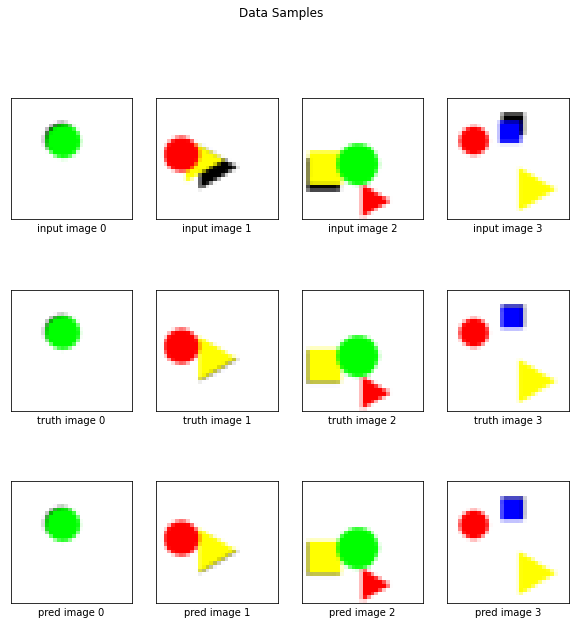

{'BATCH_SIZE': 30,
 'CLASSES': ['square_red',
             'square_green',
             'square_blue',
             'square_yellow',
             'triangle_red',
             'triangle_green',
             'triangle_blue',
             'triangle_yellow',
             'circular_red',
             'circular_green',
             'circular_blue',
             'circular_yellow'],
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 32,
 'IMAGE_WIDTH': 32,
 'LEARNING_RATE': 0.01,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_EPOCHS': 5,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'SEQUENCE_LENGTH': 10,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


In [10]:
if cfg.DEBUG_MODE:
    t_x, t_y,_ = next(train_batch_generator)
    print('train_x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('train_y', t_y.shape, t_y.dtype, t_y.min(), t_y.max()) 
    plot_sample_lastframepredictor_data_with_groundtruth(t_x, t_y, t_y)
    pprint.pprint (cfg)

7) Start timer and init matrices

In [11]:
start_time = datetime.now()
# Adversarial loss ground truths
valid = -np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)
fake = np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)#np.zeros((cfg.BATCH_SIZE,) + modelObj.disc_patch)
# log file
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(output_log_dir):
    os.makedirs(output_log_dir)

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


8) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configGAN.py.**

(30, 12)
1/1 [==============================] - 0s 907us/step - loss: 0.0806 - discriminator_loss: 0.0806


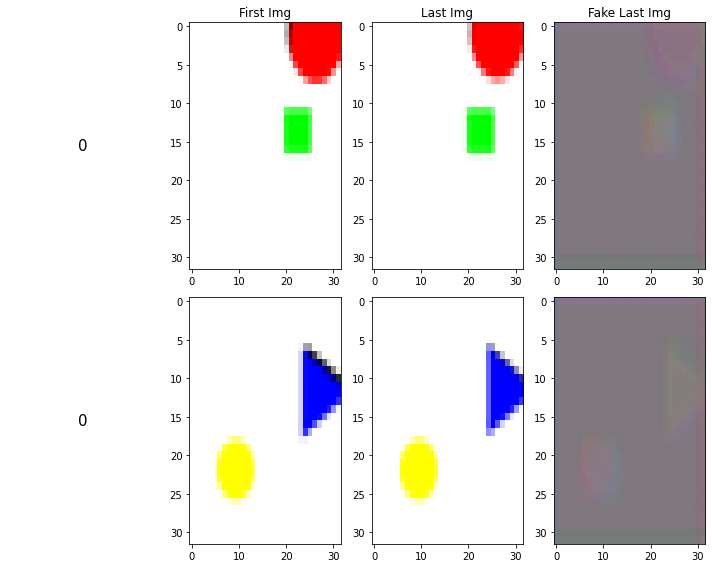

=====RUN 1 of 10=====


[Epoch 0/5] [Batch 1/360] [D loss: 0.000728] [G loss: 0.003268] time: 0:00:04.191689
[Epoch 0/5] [Batch 90/360] [D loss: -0.005220] [G loss: -0.012972] time: 0:00:16.284785
[Epoch 0/5] [Batch 180/360] [D loss: 0.000989] [G loss: -0.069972] time: 0:00:28.426075
[Epoch 0/5] [Batch 270/360] [D loss: 0.006889] [G loss: -0.075369] time: 0:00:40.569409
[Epoch 0/5] [Batch 358/360] [D loss: 0.007961] [G loss: -0.057970] time: 0:00:52.462780

1/1 [==============================] - 0s 595us/step - loss: -0.1415


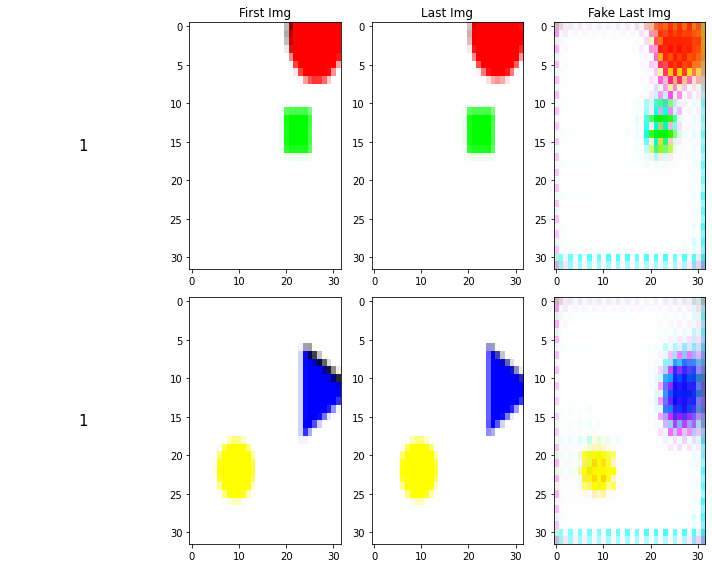

=======VALIDATION=======
D loss: -0.09847605414688587 G loss: -0.053426433354616165 
=====RUN 2 of 10=====


[Epoch 1/5] [Batch 1/360] [D loss: 0.002164] [G loss: -0.065421] time: 0:00:53.298529
[Epoch 1/5] [Batch 90/360] [D loss: 0.000665] [G loss: -0.003982] time: 0:01:05.205808
[Epoch 1/5] [Batch 180/360] [D loss: 0.000106] [G loss: -0.000402] time: 0:01:17.182334
[Epoch 1/5] [Batch 270/360] [D loss: 0.000102] [G loss: -0.000808] time: 0:01:29.210494
[Epoch 1/5] [Batch 358/360] [D loss: 0.000114] [G loss: -0.000918] time: 0:01:40.972894

1/1 [==============================] - 0s 634us/step - loss: -0.0025


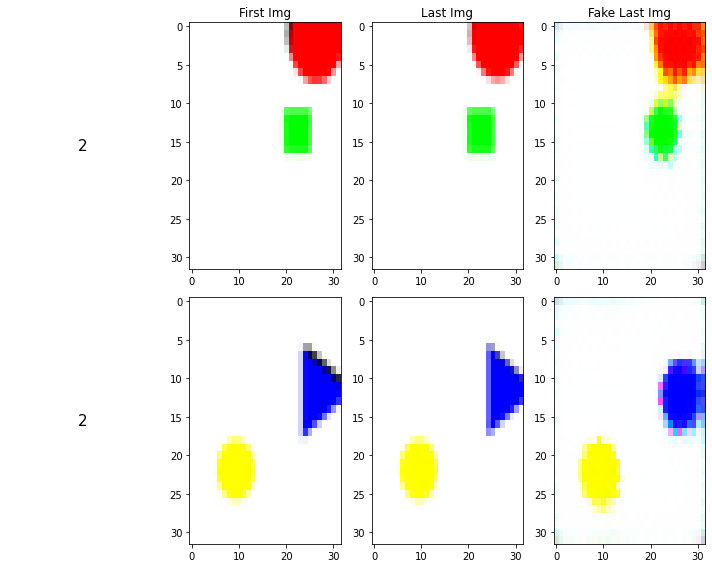

=======VALIDATION=======
D loss: -0.0017203987808898091 G loss: -0.0009143727365881205 
=====RUN 3 of 10=====


[Epoch 2/5] [Batch 1/360] [D loss: 0.000137] [G loss: -0.000952] time: 0:01:41.809685
[Epoch 2/5] [Batch 90/360] [D loss: 0.000094] [G loss: -0.001029] time: 0:01:53.686954
[Epoch 2/5] [Batch 180/360] [D loss: 0.000195] [G loss: -0.000891] time: 0:02:05.848475
[Epoch 2/5] [Batch 270/360] [D loss: 0.000052] [G loss: -0.000988] time: 0:02:17.870185
[Epoch 2/5] [Batch 358/360] [D loss: -0.000021] [G loss: -0.000840] time: 0:02:29.890527

1/1 [==============================] - 0s 767us/step - loss: -0.0078


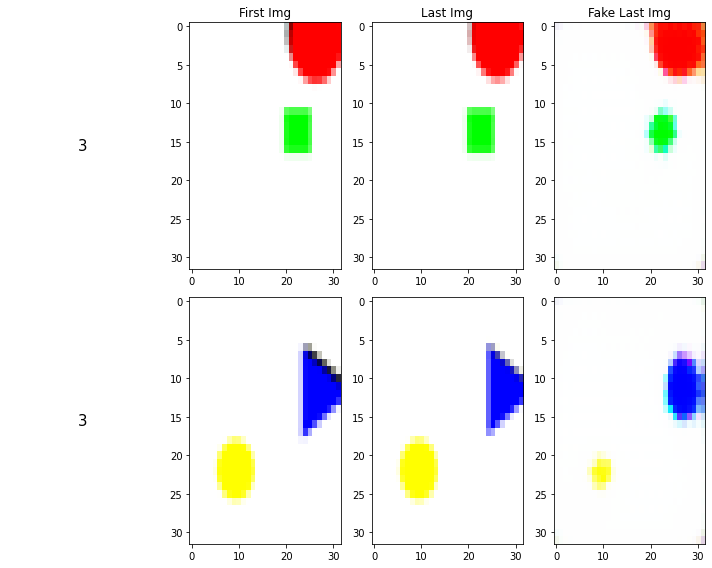

=======VALIDATION=======
D loss: -0.004331902804551646 G loss: -0.0009020613506436348 
=====RUN 4 of 10=====


[Epoch 3/5] [Batch 90/360] [D loss: 0.000072] [G loss: -0.001029] time: 0:02:43.057776



KeyboardInterrupt: 

In [13]:
from tqdm.notebook import tqdm, trange

import imageio 
test_first_imgs, test_last_imgs,test_labels = next(test_batch_generator)

plot_first_imgs, plot_last_imgs, plot_lables_imgs = next(valid_batch_generator)

plot_lables_imgs = label_encoder(plot_lables_imgs)#mapLabels(plot_lables_imgs)
print(plot_lables_imgs.shape)

disc_losses_val = []
generator_losses_val = []
disc_accuracies_val_fake = []
disc_accuracies_val_real = []
conditional = True
plot_epoch = False
plots = []

                

fake_last_frames_plot = modelObj.generator.predict([plot_first_imgs,plot_lables_imgs])
# Train the discriminator with combined loss  
d_loss_real = modelObj.discriminator.evaluate([plot_last_imgs, plot_first_imgs,plot_lables_imgs], valid)#modelObj.discriminator.train_on_batch([plot_last_imgs, plot_first_imgs,plot_lables_imgs], valid)
d_loss_fake = modelObj.discriminator.evaluate([fake_last_frames_plot, plot_first_imgs,plot_lables_imgs], fake)#modelObj.discriminator.train_on_batch([fake_last_frames_plot, plot_first_imgs,plot_lables_imgs], fake)
d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

# Train the generator
g_loss = modelObj.combined.evaluate([plot_last_imgs, plot_first_imgs,plot_lables_imgs], [valid, plot_last_imgs])

#disc_accuracies_val_fake.append(d_loss_fake[1])
#disc_accuracies_val_real.append(d_loss_real[1])
disc_losses_val.append(d_loss)
generator_losses_val.append(g_loss[0])

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
rows = 2
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(10, 8))
for ax, batch_i in zip(axs, range(rows)):

    ax[0].text(0.5*(left+right), 0.5*(bottom+top), 0,
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=15)
    ax[0].axis('off')
    for i, img in zip(range(1,4), [["First Img", plot_first_imgs[batch_i]], ["Last Img", plot_last_imgs[batch_i]], ["Fake Last Img", fake_last_frames_plot[batch_i]]]):
        ax[i].imshow(img[1])
        if(batch_i == 0):
            ax[i].set_title(img[0])
        ax[i].axis('auto')

plt.tight_layout()
plt.show()
fig.canvas.draw()       # draw the canvas, cache the renderer
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plots.append(image)


for epoch in range(20):#cfg.NUM_EPOCHS):
    print("=====RUN {} of {}=====".format(epoch+1,10))
    steps_per_epoch = (nbr_train_data // 30) 
    for batch_i in trange(steps_per_epoch):
        first_frames, last_frames, image_labels = next(train_batch_generator)
        if first_frames.shape[0] == cfg.BATCH_SIZE: 
            #print(first_frames.shape)
            image_labels = label_encoder(image_labels)#mapLabels(image_labels)
            
            
            for x in range(5):
                fake_last_frames = modelObj.generator([first_frames,image_labels])

                # Train the discriminator with combined loss  
                d_loss_real = modelObj.discriminator.train_on_batch([last_frames, first_frames,image_labels], valid)
                d_loss_fake = modelObj.discriminator.train_on_batch([fake_last_frames, first_frames,image_labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            g_loss = modelObj.combined.train_on_batch( [last_frames,first_frames,image_labels], [valid,last_frames])



            elapsed_time = datetime.now() - start_time 

            if  batch_i in [1,90,180,270,358]:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] time: %s" % (epoch, cfg.NUM_EPOCHS,
                                                                                               batch_i,
                                                                                               steps_per_epoch,
                                                                                               d_loss, 
                                                                                               g_loss[0],
                                                                                               elapsed_time))
    #CGAN
    fake_last_frames = modelObj.generator.predict([plot_first_imgs,plot_lables_imgs])

    # Train the discriminator with combined loss  
    d_loss_real = modelObj.discriminator.evaluate([plot_last_imgs, plot_first_imgs,plot_lables_imgs], valid)
    d_loss_fake = modelObj.discriminator.evaluate([fake_last_frames_plot, plot_first_imgs,plot_lables_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train the generator
    g_loss = modelObj.combined.evaluate([plot_last_imgs, plot_first_imgs,plot_lables_imgs], [valid, plot_last_imgs],verbose=0)

    #disc_accuracies_val_fake.append(d_loss_fake[1])
    #disc_accuracies_val_real.append(d_loss_real[1])
    disc_losses_val.append(d_loss)
    generator_losses_val.append(g_loss[0])

    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    #fake_last_plotFrames = modelObj.generator.predict([plot_first_imgs,plot_lables_imgs])
    rows = 2
    fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(10, 8))
    for ax, batch_i in zip(axs, range(rows)):

        ax[0].text(0.5*(left+right), 0.5*(bottom+top), epoch + 1,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15)
        ax[0].axis('off')
        for i, img in zip(range(1,4), [["First Img", plot_first_imgs[batch_i]], ["Last Img", plot_last_imgs[batch_i]], ["Fake Last Img", fake_last_frames[batch_i]]]):
            ax[i].imshow(img[1])
            if(batch_i == 0):
                ax[i].set_title(img[0])
            ax[i].axis('auto')


    plt.tight_layout()
    plt.show()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)

    print("=======VALIDATION=======")
    print("D loss: {} G loss: {} ".format(d_loss,g_loss[0],g_loss))

    
imageio.mimsave('./powers.gif', plots, fps=3)

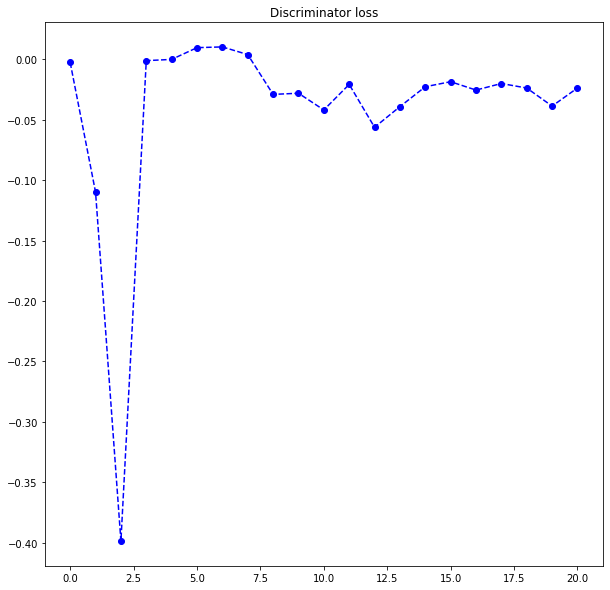

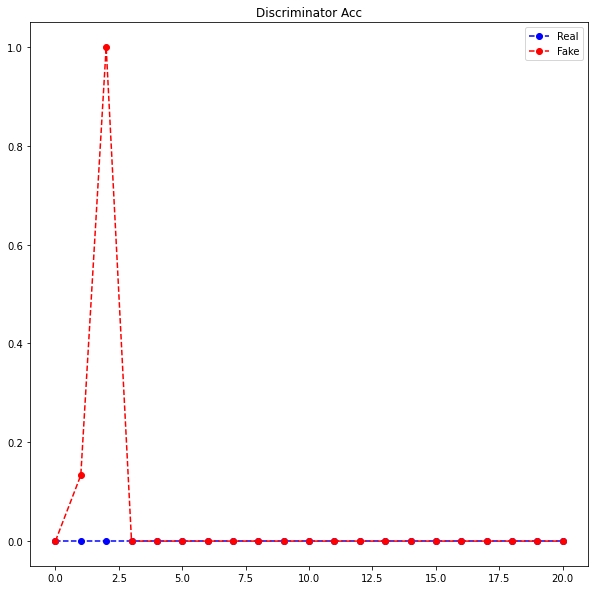

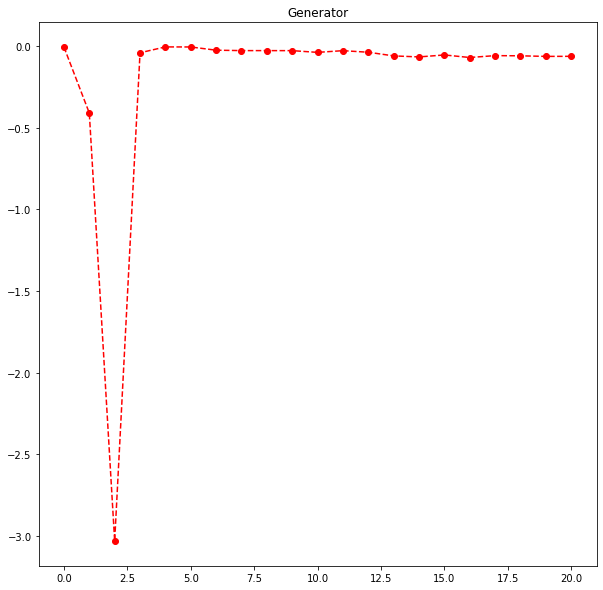

In [385]:
fig = plt.figure(figsize=(10,10))

plt.plot(disc_losses_val,label="Discriminator Loss",color="b",linestyle="--",marker='o')
plt.title('Discriminator loss')
plt.show()

fig = plt.figure(figsize=(10,10))
plt.plot(disc_accuracies_val_real,label="Real",color="b",linestyle="--",marker='o')
plt.plot(disc_accuracies_val_fake,label="Fake",color="r",linestyle="--",marker='o')
plt.legend()
plt.title('Discriminator Acc')
plt.show()


fig = plt.figure(figsize=(10,10))
plt.plot(generator_losses_val,label="Generator Loss",color="r",linestyle="--",marker='o')
plt.title('Generator')
plt.show()

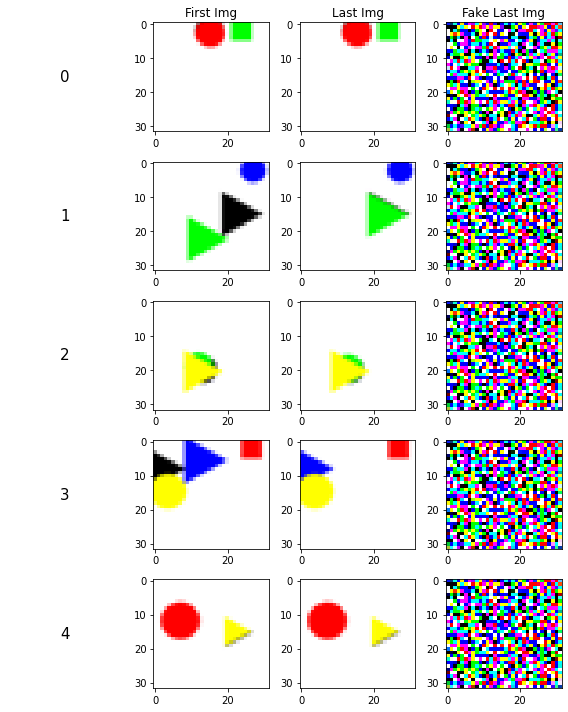

In [27]:
rows = 5
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height


for ax, batch_i in zip(axs, range(rows)):
    test_first_imgs, test_last_imgs,test_lables = next(test_batch_generator)
    test_lables = label_encoder(test_lables)

    test_fake_last_imgs = modelObj.generator.predict([test_first_imgs,test_lables]) 
    #test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    #merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    #imageio.imwrite(test_img_name, img_as_ubyte(merged_img))
    ax[0].text(0.5*(left+right), 0.5*(bottom+top), batch_i,
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=15)
    ax[0].axis('off')
    for i, img in zip(range(1,4), [["First Img", test_first_imgs[0]], ["Last Img", test_last_imgs[0]], ["Fake Last Img", test_fake_last_imgs[0]]]):
        ax[i].imshow(img[1])
        if(batch_i == 0):
            ax[i].set_title(img[0])
        ax[i].axis('auto')


plt.tight_layout()
plt.show()

In [ ]:
# from scipy.interpolate import make_interp_spline, BSpline

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# epochs = np.linspace(1, cfg.NUM_EPOCHS, cfg.NUM_EPOCHS)

# for ax, data in zip(axs, [["Discriminator Mean Loss", d_loss_data], ["Generator Mean Loss", g_loss_data]]):
    
#     # 300 represents number of points to make between T.min and T.max
#     xnew = np.linspace(1, cfg.NUM_EPOCHS, 100) 

#     spl = make_interp_spline(epochs, data[1], k=3)  # type: BSpline
#     data_smooth = spl(xnew)

#     ax.plot(xnew, data_smooth)
#     ax.legend(data)
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Mean Loss')


# plt.tight_layout()
# plt.show()

9) We can test the model with 100 test data which will be saved as images

In [163]:
discriminator_losses = []
disc_real_acc = []
disc_fake_acc = []
discriminator_accuracies = []
generator_losses = []
for batch_i in range(100):
    test_first_imgs, test_last_imgs, test_labels = next(test_batch_generator)
    test_labels = mapLabels(test_labels)
    test_fake_last_imgs = modelObj.generator.predict([test_first_imgs,test_labels])     
    d_loss_real = modelObj.discriminator.train_on_batch([test_last_imgs, test_first_imgs,test_labels], valid)
    d_loss_fake = modelObj.discriminator.train_on_batch([test_fake_last_imgs, test_first_imgs,test_labels], fake)
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
 
    # Train the generator
    g_loss = modelObj.combined.train_on_batch([test_last_imgs, test_first_imgs,test_labels], [valid, test_last_imgs])
    
    discriminator_losses.append(d_loss[0])
    discriminator_accuracies.append(d_loss[1])
    generator_losses.append(g_loss[0])
    
    disc_real_acc.append(d_loss_real[1])
    disc_fake_acc.append(d_loss_fake[1])
    #print(d_loss)
    
    
    
    #test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    #merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    #imageio.imwrite(test_img_name, img_as_ubyte(merged_img))

disc_real_accuracy = round(np.array(disc_real_acc).mean(),4)
disc_fake_accuracy = round(np.array(disc_fake_acc).mean(),4)

print("Real Images:{}".format(disc_real_accuracy))
print("Fake Images: {}".format(disc_fake_accuracy))
disc_loss = round(np.array(discriminator_losses).mean(),4)
disc_acc = round(np.array(discriminator_accuracies).mean(),4)
gen_loss = round(np.array(generator_losses).mean(),4)

print("Discriminator loss: {} ----- Discriminator acc: {} ----- Generator loss: {}".format(disc_loss,disc_acc,gen_loss))

KeyboardInterrupt: 

## EXERCISES

#### Exercise 1)
Update the network architecture given in  **build_generator**  and  **build_discriminator**  of the class GANModel. Please note that the current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT values) in the file configGAN.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. data augmentation, dropout) methods to increase the network accuracy. 